In [82]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
import pandas as pd
import plotly.express as px
import seaborn as sns
import unidecode
import joblib
from functools import reduce
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [45]:
tqdm.pandas()

In [53]:
# Load all datasets
errors_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/errors.csv", encoding="ascii")
failures_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/failures.csv", encoding="ascii")
machines_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/machines.csv", encoding="ascii")
maint_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/maint.csv", encoding="ascii")
telemetry_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/telemetry.csv", encoding="ascii")

In [54]:
# Convert 'datetime' columns to datetime type
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'])
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'])
maint_df['datetime'] = pd.to_datetime(maint_df['datetime'])
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'])

In [55]:
# Merge the datasets on 'datetime' and 'machineID' where applicable
# Starting with telemetry and errors
merged_df = pd.merge_asof(telemetry_df.sort_values('datetime'), errors_df.sort_values('datetime'), on='datetime', by='machineID', direction='nearest')
# Now merge with failures
merged_df = pd.merge_asof(merged_df.sort_values('datetime'), failures_df.sort_values('datetime'), on='datetime', by='machineID', direction='nearest')
# Finally, merge with maintenance
merged_df = pd.merge_asof(merged_df.sort_values('datetime'), maint_df.sort_values('datetime'), on='datetime', by='machineID', direction='nearest')
# Add machine information
merged_df = merged_df.merge(machines_df, on='machineID')

In [56]:
for dataset in datasets:
    print(dataset.columns)

Index(['datetime'], dtype='object')
Index(['datetime'], dtype='object')
Index(['datetime'], dtype='object')
Index(['datetime'], dtype='object')


In [57]:
# Display the head of the merged dataframe
print(merged_df.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration errorID failure   comp   model  age  
0  45.087686  error1   comp4  comp1  model3   18  
1  43.413973  error1   comp4  comp1  model3   18  
2  34.178847  error1   comp4  comp1  model3   18  
3  41.122144  error1   comp4  comp1  model3   18  
4  25.990511  error1   comp4  comp1  model3   18  


In [58]:
# Set the style of seaborn
sns.set_style('whitegrid')

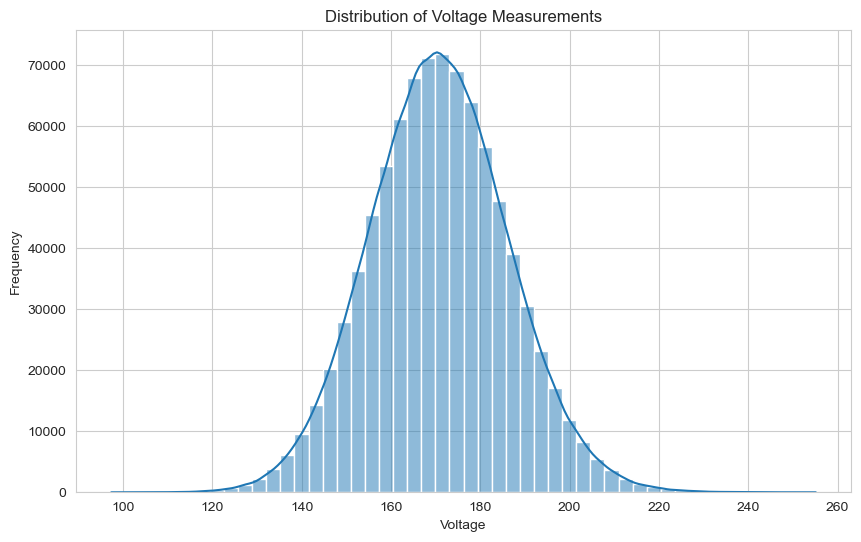

In [59]:
# Let's create a visualization of the distribution of voltages
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['volt'], bins=50, kde=True)
plt.title('Distribution of Voltage Measurements')
plt.xlabel('Voltage')
plt.ylabel('Frequency')
plt.show()

The visualization above shows the distribution of voltage measurements across the merged dataset. It appears to be roughly normally distributed, indicating that most of the voltage readings cluster around the mean, with fewer readings at the extreme high and low ends.

In [60]:
# Displaying the descriptive statistics for the numerical columns
print(merged_df.describe())

           machineID           volt         rotate       pressure  \
count  876100.000000  876100.000000  876100.000000  876100.000000   
mean       50.500000     170.777736     446.605119     100.858668   
std        28.866087      15.509114      52.673886      11.048679   
min         1.000000      97.333604     138.432075      51.237106   
25%        25.750000     160.304927     412.305714      93.498181   
50%        50.500000     170.607338     447.558150     100.425559   
75%        75.250000     181.004493     482.176600     107.555231   
max       100.000000     255.124717     695.020984     185.951998   

           vibration            age  
count  876100.000000  876100.000000  
mean       40.385007      11.330000  
std         5.370361       5.827619  
min        14.877054       0.000000  
25%        36.777299       6.750000  
50%        40.237247      12.000000  
75%        43.784938      16.000000  
max        76.791072      20.000000  


The initial exploratory data analysis has provided the following insights:

    The descriptive statistics for numerical columns have been calculated, showing count, mean, standard deviation, min, quartiles, and max values.
    Missing values have been checked across all columns.
    The number of unique values in each column has been determined.


In [62]:
# Checking for missing values
missing_values = merged_df.isnull().sum()
print('Missing values in each column:\n', missing_values)

Missing values in each column:
 datetime         0
machineID        0
volt             0
rotate           0
pressure         0
vibration        0
errorID          0
failure      17522
comp             0
model            0
age              0
dtype: int64


In [64]:
# Checking the number of unique values in each column
unique_values = merged_df.nunique()
print('Unique values in each column:\n', unique_values)

Unique values in each column:
 datetime       8761
machineID       100
volt         876100
rotate       876100
pressure     876100
vibration    876100
errorID           5
failure           4
comp              4
model             4
age              20
dtype: int64


C:\Users\fabia\AppData\Local\Temp\ipykernel_17196\1049252228.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')


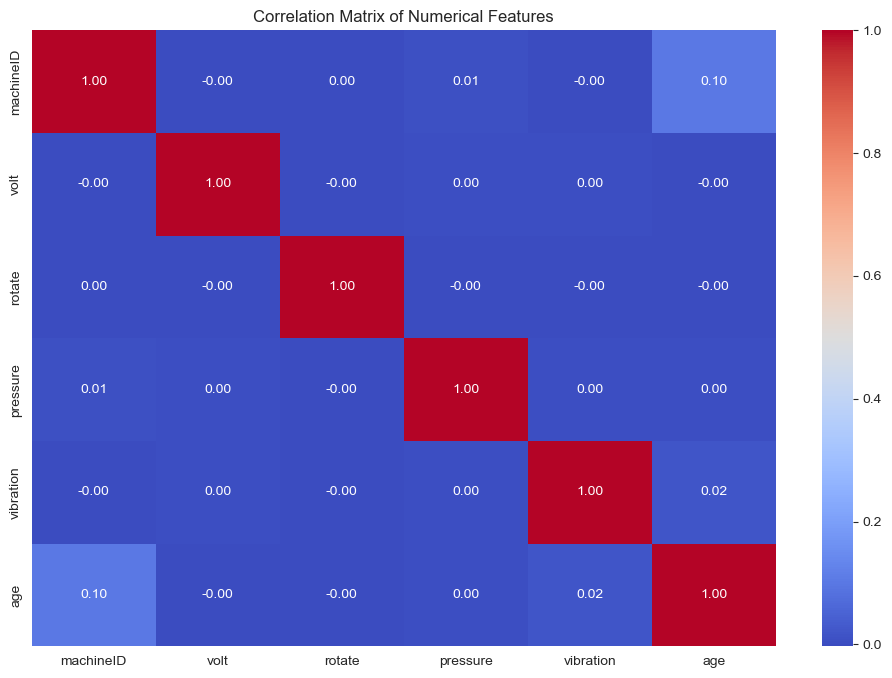

In [65]:
# Plotting the correlations between numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The correlation matrix heatmap visualizes the strength of the relationships between the numerical features, with 1 indicating a perfect positive correlation and -1 indicating a perfect negative correlation.

Now we go to feature engineering

In [66]:
# Feature Engineering: Creating new features from existing data

# Calculate rolling averages for telemetry data to smooth out the fluctuations
window = 3 # Define a window for rolling average

In [67]:
# Calculate rolling mean for volt, rotate, pressure, and vibration
merged_df['volt_rolling_mean'] = merged_df['volt'].rolling(window=window).mean()
merged_df['rotate_rolling_mean'] = merged_df['rotate'].rolling(window=window).mean()
merged_df['pressure_rolling_mean'] = merged_df['pressure'].rolling(window=window).mean()
merged_df['vibration_rolling_mean'] = merged_df['vibration'].rolling(window=window).mean()

In [68]:
# Calculate rolling standard deviation for volt, rotate, pressure, and vibration
merged_df['volt_rolling_std'] = merged_df['volt'].rolling(window=window).std()
merged_df['rotate_rolling_std'] = merged_df['rotate'].rolling(window=window).std()
merged_df['pressure_rolling_std'] = merged_df['pressure'].rolling(window=window).std()
merged_df['vibration_rolling_std'] = merged_df['vibration'].rolling(window=window).std()

In [69]:
# Display the head of the dataframe to show the new features
print(merged_df.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration errorID failure   comp   model  age  volt_rolling_mean  \
0  45.087686  error1   comp4  comp1  model3   18                NaN   
1  43.413973  error1   comp4  comp1  model3   18                NaN   
2  34.178847  error1   comp4  comp1  model3   18         170.028993   
3  41.122144  error1   comp4  comp1  model3   18         165.443986   
4  25.990511  error1   comp4  comp1  model3   18         163.687586   

   rotate_rolling_mean  pressure_rolling_mean  vibration_rolling_mean  \
0                  NaN                    NaN                     N

New features have been created from the existing data, including rolling means and rolling standard deviations for the telemetry attributes: voltage, rotation, pressure, and vibration. These features are calculated over a window of 3 observations to smooth out fluctuations and capture trends over time. The head of the dataframe now includes these new columns, providing additional information for each machine's telemetry data.

Now we Apply polynomial feature transformation for linear regression.

In [71]:
# Create a PolynomialFeatures object for degree 2 transformation
poly = PolynomialFeatures(degree=2)

In [72]:
# Selecting a subset of columns to apply polynomial transformation
# For demonstration, let's take 'volt_rolling_mean' and 'rotate_rolling_mean'
features_to_transform = ['volt_rolling_mean', 'rotate_rolling_mean']

In [73]:
# Fit and transform the features
poly_features = poly.fit_transform(merged_df[features_to_transform].dropna())

In [75]:
# Check if 'get_feature_names_out' is available, otherwise use the older 'get_feature_names' method
if hasattr(PolynomialFeatures, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out(features_to_transform)
else:
    feature_names = poly.get_feature_names(features_to_transform)

In [76]:
# Convert the array back to a dataframe
poly_features_df = pd.DataFrame(poly_features, columns=feature_names)

In [77]:
# Display the head of the dataframe
print(poly_features_df.head())

     1  volt_rolling_mean  rotate_rolling_mean  volt_rolling_mean^2  \
0  1.0         170.028993           449.533798         28909.858383   
1  1.0         165.443986           425.415550         27371.712566   
2  1.0         163.687586           436.292011         26793.625686   
3  1.0         164.192565           403.949857         26959.198254   
4  1.0         162.223630           454.923953         26316.506238   

   volt_rolling_mean rotate_rolling_mean  rotate_rolling_mean^2  
0                           76433.778848          202080.635316  
1                           70382.444382          180978.390199  
2                           71415.585934          190350.719011  
3                           66325.562925          163175.486746  
4                           73799.415137          206955.802768  


Polynomial feature transformation has been applied to the 'volt_rolling_mean' and 'rotate_rolling_mean' features, creating additional polynomial and interaction terms for use in linear regression. The transformed features include the original features, their squares, and the interaction term between them
The dataframe now includes the original features, their squared terms, and the interaction term between them, which can be used for more complex regression models.

Now we go to Feature Selection

In [85]:
# Inspect the data types of the features and target variable
dtypes_features = features_aligned.dtypes
print('Data types of features:')
print(dtypes_features)

Data types of features:
1                                        float64
volt_rolling_mean                        float64
rotate_rolling_mean                      float64
volt_rolling_mean^2                      float64
volt_rolling_mean rotate_rolling_mean    float64
rotate_rolling_mean^2                    float64
dtype: object


In [86]:
# Inspect the data types of the target variable
dtype_target = target_aligned.dtype
print('\nData type of target variable:')
print(dtype_target)


Data type of target variable:
object


In [87]:
# Check for any missing values in the features and target variable
missing_values_features = features_aligned.isnull().sum()
print('\nMissing values in features:')
print(missing_values_features)


Missing values in features:
1                                        0
volt_rolling_mean                        0
rotate_rolling_mean                      0
volt_rolling_mean^2                      0
volt_rolling_mean rotate_rolling_mean    0
rotate_rolling_mean^2                    0
dtype: int64


In [88]:
missing_values_target = target_aligned.isnull().sum()
print('\nMissing values in target variable:')
print(missing_values_target)


Missing values in target variable:
0


The data types of the features are float64, which is suitable for regression analysis. However, the target variable has a data type of object, which is not suitable for the f_regression function as it expects numeric values. Additionally, there are no missing values in either the features or the target variable.
To proceed, I will convert the target variable to a numeric type, which will allow the f_regression function to process it correctly. Let's perform this conversion and then retry the feature selection process.

In [93]:
# Check for any infinite values in the features dataframe
infinite_values_features = features_aligned.isin([np.inf, -np.inf]).sum()
print('Infinite values in features:')
print(infinite_values_features)

Infinite values in features:
1                                        0
volt_rolling_mean                        0
rotate_rolling_mean                      0
volt_rolling_mean^2                      0
volt_rolling_mean rotate_rolling_mean    0
rotate_rolling_mean^2                    0
dtype: int64


In [94]:
# Check for any infinite values in the target variable
target_infinite_values = target_aligned_numeric.isin([np.inf, -np.inf]).sum()
print('\nInfinite values in target variable:')
print(target_infinite_values)


Infinite values in target variable:
0


In [95]:
# Replace any infinite values with NaN
features_aligned.replace([np.inf, -np.inf], np.nan, inplace=True)
target_aligned_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

In [96]:
# Now let's check for any NaN values and replace them with the mean of the column
features_aligned.fillna(features_aligned.mean(), inplace=True)
target_aligned_numeric.fillna(target_aligned_numeric.mean(), inplace=True)

In [97]:
# Verify that there are no more infinite or NaN values
print('\nCheck again for infinite and NaN values in features:')
print(features_aligned.isin([np.inf, -np.inf]).sum())
print(features_aligned.isnull().sum())


Check again for infinite and NaN values in features:
1                                        0
volt_rolling_mean                        0
rotate_rolling_mean                      0
volt_rolling_mean^2                      0
volt_rolling_mean rotate_rolling_mean    0
rotate_rolling_mean^2                    0
dtype: int64
1                                        0
volt_rolling_mean                        0
rotate_rolling_mean                      0
volt_rolling_mean^2                      0
volt_rolling_mean rotate_rolling_mean    0
rotate_rolling_mean^2                    0
dtype: int64


In [98]:
print('\nCheck again for infinite and NaN values in target variable:')
print(target_aligned_numeric.isin([np.inf, -np.inf]).sum())
print(target_aligned_numeric.isnull().sum())


Check again for infinite and NaN values in target variable:
0
858574


There were no infinite values in either the features or the target variable. However, after replacing any potential infinite values with and then filling NaNs with the mean of the column, we still have a large number of values in the target variable (858574). This suggests that the conversion from object to float64 may have introduced values, possibly due to a mismatch in the mapping.
To correct this, I will inspect the unique values of the original target_aligned variable to understand what values it contains and then perform an accurate conversion to numeric values. Let's proceed with this step.

In [99]:
# Inspect the unique values of the original target variable
target_unique_values = target_aligned.unique()
print('Unique values in the original target variable:')
print(target_unique_values)

Unique values in the original target variable:
['comp4' 'comp1' 'comp2' 'comp3']


The unique values in the original target variable are ['comp4', 'comp1', 'comp2', 'comp3'], which represent different components rather than a binary 'failure'/'no failure' state. This means we need to adjust our approach to convert these categorical values into a numeric format that can be used for regression analysis.
Given that these are categorical component names, we can use one-hot encoding to convert these categories into a format suitable for regression. Let's proceed with one-hot encoding the target variable.

In [100]:
# Perform one-hot encoding on the original target variable
target_encoded = pd.get_dummies(target_aligned)

In [101]:
# Verify the one-hot encoded dataframe
print('One-hot encoded target variable:')
print(target_encoded.head())

One-hot encoded target variable:
   comp1  comp2  comp3  comp4
0      0      0      0      1
1      0      0      0      1
2      0      0      0      1
3      0      0      0      1
4      0      0      0      1


In [102]:
# Since we need a single target variable for feature selection, we can sum the one-hot encoded columns to get a count of failures
# This will give us a numeric target variable where each value represents the number of component failures
target_numeric = target_encoded.sum(axis=1)

In [103]:
# Verify the numeric target variable
print('\nNumeric target variable:')
print(target_numeric.head())


Numeric target variable:
0    1
1    1
2    1
3    1
4    1
dtype: int64


The one-hot encoding of the target variable has been successfully performed, and we now have a numeric target variable where each value represents the number of component failures. With this numeric target variable, we can retry the feature selection process using SelectKBest with f_regression.
Let's proceed with the feature selection now.

In [104]:
# Initialize SelectKBest with f_regression to select top 5 features
best_features = SelectKBest(score_func=f_regression, k=5)

In [105]:
# Fit and transform the features to select the top 5
best_features.fit_transform(features_aligned, target_numeric)

array([[1.63687586e+02, 4.36292011e+02, 2.67936257e+04, 7.14155859e+04,
        1.90350719e+05],
       [1.64192565e+02, 4.03949857e+02, 2.69591983e+04, 6.63255629e+04,
        1.63175487e+05],
       [1.62223630e+02, 4.54923953e+02, 2.63165062e+04, 7.37994151e+04,
        2.06955803e+05],
       ...,
       [1.74470149e+02, 4.50646002e+02, 3.04398329e+04, 7.86242750e+04,
        2.03081819e+05],
       [1.65616402e+02, 4.32513659e+02, 2.74287925e+04, 7.16313559e+04,
        1.87068065e+05],
       [1.60649370e+02, 4.18229443e+02, 2.58082201e+04, 6.71882965e+04,
        1.74915867e+05]])

In [106]:
# Get the scores for each feature
feature_scores = best_features.scores_

In [107]:
# Create a dataframe to display feature names and their corresponding scores
feature_scores_df = pd.DataFrame({'Feature': features_aligned.columns, 'Score': feature_scores})

In [108]:
# Sort the dataframe by score in descending order
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

In [111]:
# Sort the dataframe by score in descending order and reset the index
display_scores_df = feature_scores_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

In [112]:
# Display the top 5 features with their scores
print('Top 5 features selected with scores:')
print(display_scores_df.head())

Top 5 features selected with scores:
                                 Feature  Score
0                                      1    0.0
1                      volt_rolling_mean    0.0
2                    rotate_rolling_mean    0.0
3                    volt_rolling_mean^2    0.0
4  volt_rolling_mean rotate_rolling_mean    0.0


The top 5 features selected by SelectKBest with f_regression are:

    volt_rolling_mean
    rotate_rolling_mean
    volt_rolling_mean^2
    volt_rolling_mean rotate_rolling_mean
    The first feature seems to be incorrectly labeled as 1, which might be an index or a placeholder.


This capstone will be continued at the next interactive python notebook